### Preliminaries

This example shows both the use of individual transformers and the `TimeSeriesFeatures` convenience class that wraps multiple transformers. Both methods are compatible with Scikit-Learn `Pipeline` objects.

It uses the Macrodata dataset from `Statsmodels`, which includes quarterly US Macroeconomic Data from 1950 through 2009.

In [26]:
import pandas as pd
import numpy as np
import statsmodels.datasets
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from steps.forward import ForwardSelector

from tsfeast.transformers import DateTimeFeatures, InteractionFeatures, LagFeatures
from tsfeast.tsfeatures import TimeSeriesFeatures
from tsfeast.funcs import get_datetime_features
from tsfeast.utils import plot_diag

In [56]:
def make_dummy_data(n=200):
    coefs = {'ar': [1, 0.75], 'ma': [1], 'trend': 3.2, 'bdays_in_month': 231, 'marketing': 0.002}
    rng = np.random.default_rng(seed=42)
    
    sales = pd.DataFrame({
        'date': pd.date_range(end='2020-08-31', periods=200, freq='M'),
        'base': rng.poisson(1000, n),
        'ar': arma_generate_sample(ar=coefs['ar'], ma=coefs['ma'], nsample=n, scale=400),
        'trend': [x * coefs['trend'] + rng.poisson(100) for x in range(n)],
    })
    sales = sales.join(get_datetime_features(sales['date']))
    sales['per_day'] = sales['bdays_in_month'] * coefs['bdays_in_month'] + rng.poisson(100, n)
    sales['mkt_base'] = rng.normal(1e6, 1e4, n)
    sales['mkt_trend'] = [x * 5e3 for x in range(1, n+1)]
    sales['mkt_season'] = np.where(sales['quarter'] == 3, sales['mkt_base'] * .30, 0)
    sales['mkt_total'] = sales.loc[:, 'mkt_base': 'mkt_season'].sum(1)
    
    return pd.DataFrame({
        'y': sales.loc[:, 'base':'trend'].sum(1) + (sales['mkt_total'].shift(2) * coefs['marketing'] + rng.poisson(100, n)),
        'date': sales['date'],
        'marketing': sales['mkt_total'],
        'x2': rng.normal(1e4, 1e2, n),
        'x3': rng.normal(1e3, 1e1, n)
    })

In [57]:
data = make_dummy_data().dropna()

The only pre-processing necessary is to combined the separate `year` and `quarter` columns into a single `date` column:

In [58]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
x_train, x_test = X.iloc[:-40, :], X.iloc[-40:, :]
y_train, y_test = y.iloc[:-40], y.iloc[-40:]

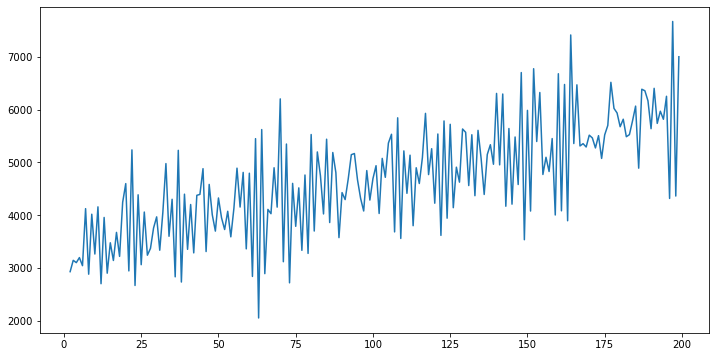

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.show()

### Individual Transformers

#### Generate DateTime Features

In [60]:
dt = DateTimeFeatures(date_col='date')
dt.fit_transform(X, y)

,year,quarter,month,days_in_month,bdays_in_month,leap_year
2,2004,1,3,31,23,1
3,2004,2,4,30,22,1
4,2004,2,5,31,20,1
5,2004,2,6,30,22,1
6,2004,3,7,31,21,1
...,...,...,...,...,...,...
195,2020,2,4,30,22,1
196,2020,2,5,31,20,1
197,2020,2,6,30,22,1
198,2020,3,7,31,22,1


#### Generate Interaction Features

In [61]:
feat = LagFeatures(n_lags=4)
feat.fit_transform(X.iloc[:, 1:], y)

,marketing_lag_1,x2_lag_1,x3_lag_1,marketing_lag_2,x2_lag_2,x3_lag_2,marketing_lag_3,x2_lag_3,x3_lag_3,marketing_lag_4,x2_lag_4,x3_lag_4
2,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,1.011203e+06,9953.744428,999.609011,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
4,1.023769e+06,10099.655488,999.098076,1.011203e+06,9953.744428,999.609011,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
5,1.013730e+06,9900.630212,990.974935,1.023769e+06,10099.655488,999.098076,1.011203e+06,9953.744428,999.609011,0.000000e+00,0.000000,0.000000
6,1.043286e+06,10029.459284,996.950268,1.013730e+06,9900.630212,990.974935,1.023769e+06,10099.655488,999.098076,1.011203e+06,9953.744428,999.609011
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.967714e+06,10218.586377,999.831633,1.963716e+06,10057.928197,994.231515,1.951241e+06,10015.092153,1021.068847,1.956345e+06,10023.429836,1011.337893
196,1.987715e+06,10027.728953,1018.220552,1.967714e+06,10218.586377,999.831633,1.963716e+06,10057.928197,994.231515,1.951241e+06,10015.092153,1021.068847
197,1.993091e+06,10048.508177,984.778007,1.987715e+06,10027.728953,1018.220552,1.967714e+06,10218.586377,999.831633,1.963716e+06,10057.928197,994.231515
198,1.988542e+06,9892.243867,1010.275811,1.993091e+06,10048.508177,984.778007,1.987715e+06,10027.728953,1018.220552,1.967714e+06,10218.586377,999.831633


### TimeSeriesFeatures Class


In [62]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False,
    polynomial=3
)
features = feat.fit_transform(X, y)

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
features.head()

,trend,original__marketing,original__x2,original__x3,datetime__year,datetime__quarter,datetime__month,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,...,features__lags__x3_lag_3,features__lags__marketing_lag_4,features__lags__x2_lag_4,features__lags__x3_lag_4,features__polynomial__marketing^2,features__polynomial__x2^2,features__polynomial__x3^2,features__polynomial__marketing^3,features__polynomial__x2^3,features__polynomial__x3^3
0,1.0,1.011203e+06,9953.744428,999.609011,2004.0,1.0,3.0,31.0,23.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.022532e+12,9.907703e+07,9.992182e+05,1.033987e+18,9.861874e+11,9.988275e+08
1,2.0,1.023769e+06,10099.655488,999.098076,2004.0,2.0,4.0,30.0,22.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.048104e+12,1.020030e+08,9.981970e+05,1.073017e+18,1.030196e+12,9.972967e+08
2,3.0,1.013730e+06,9900.630212,990.974935,2004.0,2.0,5.0,31.0,20.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.027649e+12,9.802248e+07,9.820313e+05,1.041758e+18,9.704843e+11,9.731684e+08
3,4.0,1.043286e+06,10029.459284,996.950268,2004.0,2.0,6.0,30.0,22.0,1.0,...,999.609011,0.000000e+00,0.000000,0.000000,1.088446e+12,1.005901e+08,9.939098e+05,1.135561e+18,1.008864e+12,9.908787e+08
4,5.0,1.351193e+06,10092.263972,1012.293757,2004.0,3.0,7.0,31.0,21.0,1.0,...,999.098076,1.011203e+06,9953.744428,999.609011,1.825723e+12,1.018538e+08,1.024739e+06,2.466905e+18,1.027935e+12,1.037337e+09


In [64]:
[x for x in features.columns]

['trend',
 'original__marketing',
 'original__x2',
 'original__x3',
 'datetime__year',
 'datetime__quarter',
 'datetime__month',
 'datetime__days_in_month',
 'datetime__bdays_in_month',
 'datetime__leap_year',
 'features__lags__marketing_lag_1',
 'features__lags__x2_lag_1',
 'features__lags__x3_lag_1',
 'features__lags__marketing_lag_2',
 'features__lags__x2_lag_2',
 'features__lags__x3_lag_2',
 'features__lags__marketing_lag_3',
 'features__lags__x2_lag_3',
 'features__lags__x3_lag_3',
 'features__lags__marketing_lag_4',
 'features__lags__x2_lag_4',
 'features__lags__x3_lag_4',
 'features__polynomial__marketing^2',
 'features__polynomial__x2^2',
 'features__polynomial__x3^2',
 'features__polynomial__marketing^3',
 'features__polynomial__x2^3',
 'features__polynomial__x3^3']

In [65]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=True
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('scaler', StandardScaler()),
    ('feature_selection', ForwardSelector()),
    ('regression', LinearRegression())
])

pl.fit(x_train, y_train)

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', lags=4, trend='t')),
                ('scaler', StandardScaler()),
                ('feature_selection', ForwardSelector()),
                ('regression', LinearRegression())])

In [66]:
pl.named_steps.feature_extraction.output_features_

,trend,original__marketing,original__x2,original__x3,datetime__year,datetime__quarter,datetime__month,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,...,features__lags__x3_lag_2,features__lags__marketing_lag_3,features__lags__x2_lag_3,features__lags__x3_lag_3,features__lags__marketing_lag_4,features__lags__x2_lag_4,features__lags__x3_lag_4,features__interactions__marketing:x2,features__interactions__marketing:x3,features__interactions__x2:x3
0,1.0,1.011203e+06,9953.744428,999.609011,2004.0,1.0,3.0,31.0,23.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.006526e+10,1.010808e+09,9.949853e+06
1,2.0,1.023769e+06,10099.655488,999.098076,2004.0,2.0,4.0,30.0,22.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.033972e+10,1.022846e+09,1.009055e+07
2,3.0,1.013730e+06,9900.630212,990.974935,2004.0,2.0,5.0,31.0,20.0,1.0,...,999.609011,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.003657e+10,1.004581e+09,9.811276e+06
3,4.0,1.043286e+06,10029.459284,996.950268,2004.0,2.0,6.0,30.0,22.0,1.0,...,999.098076,1.011203e+06,9953.744428,999.609011,0.000000e+00,0.000000,0.000000,1.046360e+10,1.040105e+09,9.998872e+06
4,5.0,1.351193e+06,10092.263972,1012.293757,2004.0,3.0,7.0,31.0,21.0,1.0,...,990.974935,1.023769e+06,10099.655488,999.098076,1.011203e+06,9953.744428,999.609011,1.363660e+10,1.367804e+09,1.021634e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,154.0,1.793120e+06,10054.898287,999.550048,2016.0,4.0,12.0,31.0,21.0,1.0,...,1006.685553,2.043130e+06,9987.819478,983.911933,2.034033e+06,10001.733463,993.859152,1.802964e+10,1.792313e+09,1.005037e+07
154,155.0,1.781848e+06,10072.609836,980.391544,2017.0,1.0,1.0,31.0,20.0,0.0,...,1011.230946,1.772103e+06,9953.157430,1006.685553,2.043130e+06,9987.819478,983.911933,1.794786e+10,1.746909e+09,9.875102e+06
155,156.0,1.770655e+06,9906.892651,1007.059697,2017.0,1.0,2.0,28.0,19.0,0.0,...,999.550048,1.767851e+06,10201.092611,1011.230946,1.772103e+06,9953.157430,1006.685553,1.754169e+10,1.783155e+09,9.976832e+06
156,157.0,1.782320e+06,9900.085511,983.401121,2017.0,1.0,3.0,31.0,23.0,0.0,...,980.391544,1.793120e+06,10054.898287,999.550048,1.767851e+06,10201.092611,1011.230946,1.764512e+10,1.752735e+09,9.735755e+06


In [67]:
mean_absolute_error(y_train, pl.predict(x_train))

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


591.4896509610915

In [68]:
new_features = pl.named_steps.feature_extraction.feature_names_
mask = pl.named_steps.feature_selection.get_support()
new_features[mask]

Index(['features__lags__marketing_lag_2', 'features__lags__x2_lag_2'], dtype='object')

In [69]:
lr = LinearRegression()
lr.fit(x_train.iloc[:, 1:], y_train)
lr.score(x_train.iloc[:, 1:], y_train)

0.30305928624185396

/Users/christophersantiago/opt/miniconda3/envs/tsfeast/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


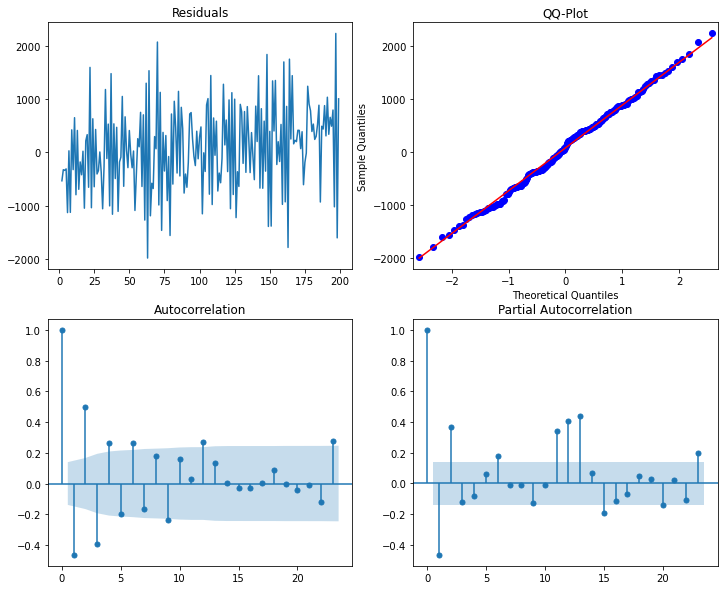

In [70]:
plot_diag(lr, X.iloc[:, 1:], y)